In [1]:
import random
import pandas as pd
import h5py
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import StratifiedGroupKFold
from pandarallel import pandarallel
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import DataStructs
from matchms import Spectrum
from matchms.exporting import save_as_mgf
import massspecgym.utils as utils
%reload_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv('../../data/data/MassSpecGym_std.tsv', sep='\t')
len(df)

231104

### Prepare SMILES and pre-computed MCES distances

In [3]:
f = h5py.File('../../data/all_smiles_standardized_mces/all_smiles_mces.hdf5', 'r')
print(list(f.keys()))
dists = squareform(f['mces'])
dists_smiles = f['mces_smiles_order'][:].astype(str).tolist()
dists.shape, len(dists_smiles)

['mces', 'mces_smiles_order']


((34731, 34731), 34731)

In [4]:
for s in df['smiles'].unique():
    assert s in dists_smiles

In [5]:
unique_smiles = df['smiles'].unique()
smiles_mask = np.array([s in unique_smiles for s in dists_smiles])
print(smiles_mask.shape[0], smiles_mask.sum(), len(unique_smiles))

dists = dists[smiles_mask, :][:, smiles_mask]
dists_smiles = np.array(dists_smiles)[smiles_mask]

from scipy.linalg import issymmetric
assert issymmetric(dists)

len(dists_smiles), dists.shape

34731 31602 31602


(31602, (31602, 31602))

### Perform agglomerative clustering using MCES distances

In [6]:
clustering = AgglomerativeClustering(
    metric='precomputed',
    linkage='single',
    distance_threshold=10,
    n_clusters=None
).fit(dists)
clusters = clustering.labels_
pd.Series(clusters).value_counts()

108     20472
379        90
934        90
918        72
115        71
        ...  
4777        1
4778        1
4779        1
3967        1
4342        1
Name: count, Length: 7484, dtype: int64

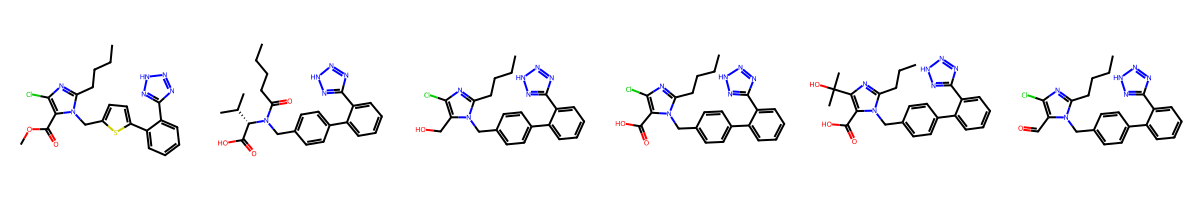

In [7]:
img = utils.show_mols(
    dists_smiles[np.where(clusters == 11)[0]].tolist(),
    smiles_in=True, legends=[], mols_per_row=6, svg=True,
    save_pth='cluster_example.svg'
)
img

### Define train-validation-test split

Compute metadata stratification groups

In [8]:
smiles_to_cluster = dict(zip(dists_smiles, clusters))
df['cluster'] = df['smiles'].map(smiles_to_cluster)

top_k_ces = df['collision_energy'].value_counts().index[:5]
smiles_vc = df['smiles'].value_counts()

def simple_ce(ce):
    if pd.isnull(ce):
        return 'none'
    if ce in top_k_ces:
        return str(ce)
    return 'other'

def simple_smiles_count(smiles):
    c = smiles_vc[smiles]
    if c < 3:
        return '(0, 3)'
    elif c <= 5:
        return '(3, 5]'
    elif c > 100:
        return '(100, inf)'
    return '(5, 100]'

def stratification_group(row):
    return str(row['adduct']) + \
        str(row['instrument_type']) + \
        str(simple_ce(row['collision_energy'])) + \
        str(simple_smiles_count(row['smiles']))
df['stratification_group'] = df.apply(stratification_group, axis=1)
df['stratification_group'].value_counts()

stratification_group
[M+H]+ITFTnone(5, 100]        37555
[M+Na]+ITFTnone(5, 100]       21223
[M+H]+QTOFother(5, 100]       17604
[M+H]+ITFTother(5, 100]       16213
[M+H]+QFTother(5, 100]        12467
                              ...  
[M+H]+nan30.0(0, 3)               1
[M+H]+nan10.0(0, 3)               1
[M+H]+QTOF45.0(0, 3)              1
[M+Na]+nannone(100, inf)          1
[M+Na]+Orbitrapother(0, 3)        1
Name: count, Length: 169, dtype: int64

Split with `StratifiedGroupKFold`

In [9]:
X = df['identifier'].values
y = df['stratification_group'].values
groups = df['cluster'].values
sgkf = StratifiedGroupKFold(n_splits=3)
sgkf_split = sgkf.split(X, y, groups)
folds = []
for i, (train_index, test_index) in enumerate(sgkf_split):
    print(f'{len(test_index)} ({len(test_index) / len(X) * 100:.2f} %)')
    folds.append(X[test_index])

/Users/roman/miniconda/envs/massspecgym/lib/python3.11/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


170096 (73.60 %)
30294 (13.11 %)
30714 (13.29 %)


In [19]:
folds_map = {}
for i, fold in enumerate(folds):
    for identifier in fold:
        folds_map[identifier] = ['train', 'val', 'test'][i]
df['fold'] = df['identifier'].map(folds_map)

def fold_composition(df_q, percentage=True):
    unique_counts = df_q.groupby(['fold']).agg({'smiles': 'nunique', 'identifier': 'nunique', 'cluster': 'nunique'})
    if not percentage:
        res = unique_counts
    else:
        total_counts = df_q.agg({'smiles': 'nunique', 'identifier': 'nunique', 'cluster': 'nunique'})
        percentage_counts = (unique_counts / total_counts) * 100
        res = percentage_counts.round(2)
    return res[['identifier', 'smiles', 'cluster']].loc[['train', 'val', 'test']]
for percentage in [False, True]:
    print(f'Full dataset (percentage={percentage})')
    display(fold_composition(df, percentage=percentage))
    print(f'All metadata available (percentage={percentage})')
    display(fold_composition(df.dropna(), percentage=percentage))

Full dataset (percentage=False)


,identifier,smiles,cluster
fold,,,
train,170096,20532,61
val,30294,5545,3721
test,30714,5525,3702


All metadata available (percentage=False)


,identifier,smiles,cluster
fold,,,
train,87883,10198,61
val,16834,4100,3190
test,16990,4107,3201


Full dataset (percentage=True)


,identifier,smiles,cluster
fold,,,
train,73.60,64.97,0.82
val,13.11,17.55,49.72
test,13.29,17.48,49.47


All metadata available (percentage=True)


,identifier,smiles,cluster
fold,,,
train,72.21,55.41,0.95
val,13.83,22.28,49.44
test,13.96,22.31,49.61


### Additionally move random validation and test clusters to the train fold

In [20]:
df_split = df.copy()
for f in ['val', 'test']:
    df_fold = df[df['fold'] == f].copy()
    rand_fold_clusters = df_fold['cluster'].drop_duplicates().sample(n=1500, random_state=42).values
    df_split.loc[df_split['cluster'].isin(rand_fold_clusters), 'fold'] = 'train'

for percentage in [False, True]:
    print(f'Full dataset (percentage={percentage})')
    display(fold_composition(df_split, percentage=percentage))
    print(f'All metadata available (percentage={percentage})')
    display(fold_composition(df_split.dropna(), percentage=percentage))

Full dataset (percentage=False)


,identifier,smiles,cluster
fold,,,
train,194119,25046,3061
val,19429,3386,2221
test,17556,3170,2202


All metadata available (percentage=False)


,identifier,smiles,cluster
fold,,,
train,101573,13543,2628
val,9975,2445,1917
test,10159,2417,1907


Full dataset (percentage=True)


,identifier,smiles,cluster
fold,,,
train,84.00,79.25,40.90
val,8.41,10.71,29.68
test,7.60,10.03,29.42


All metadata available (percentage=True)


,identifier,smiles,cluster
fold,,,
train,83.46,73.58,40.73
val,8.20,13.28,29.71
test,8.35,13.13,29.56


### Cluster sizes

In [48]:
df.drop_duplicates(subset=['inchikey']).groupby(['cluster', 'fold']).agg({'inchikey': 'count'}).sort_values(by='inchikey', ascending=False)

,,inchikey
cluster,fold,
108,train,18483
934,val,78
918,val,61
379,test,60
115,test,58
...,...,...
3151,test,1
3150,test,1
3149,val,1


In [51]:
df['inchikey'].nunique(), 18483 / df['inchikey'].nunique()

(28929, 0.6389090531992119)

### Metadata distribution

------------------------------ Full dataset ------------------------------


collision_energy
None     109358
Other     60546
20.0      18506
60.0      16015
30.0      12780
10.0       7305
45.0       6594
Name: count, dtype: int64

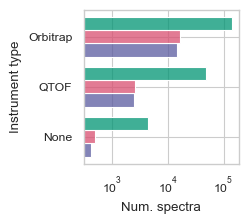

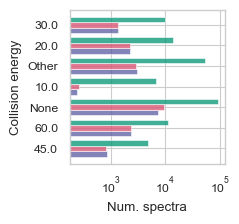

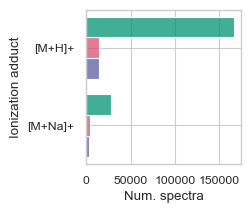

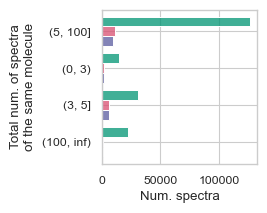

------------------------------ All metadata available ------------------------------


collision_energy
Other    60509
20.0     18506
60.0     16015
30.0     12779
10.0      7304
45.0      6594
Name: count, dtype: int64

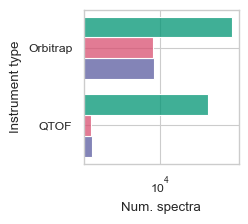

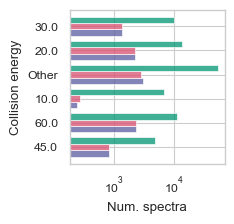

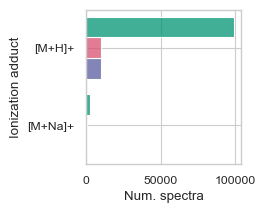

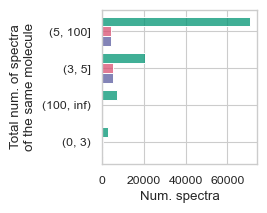

In [12]:
utils.init_plotting(figsize=(2, 2))

for df_name, df_plot in [('Full dataset', df_split.copy()), ('All metadata available', df_split.copy().dropna())]:
    print('-' * 30, df_name, '-' * 30)
    df_plot['instrument_type'] = df_plot['instrument_type'].str.replace('Q Exactive Focus Hybrid Quadrupole Orbitrap Mass Spectrometer (Thermo Fisher Scientific)', 'Q Exactive')
    df_plot['instrument_type'] = df_plot['instrument_type'].replace({'ITFT':'Orbitrap', 'QFT':'Orbitrap'})
    df_plot['instrument_type'] = df_plot['instrument_type'].fillna('None')
    df_plot['collision_energy'] = df_plot['collision_energy'].apply(simple_ce)
    df_plot['collision_energy'] = df_plot['collision_energy'].replace({'other': 'Other', 'none': 'None'})
    df_plot['fold'] = df_plot['fold'].replace({'train': 'Training', 'val': 'Validation', 'test': 'Testing'})
    df_plot = df_plot.rename({'fold': 'Fold'}, axis=1)
    display(df_plot['collision_energy'].value_counts())
    df_plot['smiles_count'] = df_plot['smiles'].apply(simple_smiles_count)

    y = 'instrument_type'
    sns.histplot(y=y, data=df_plot, hue='Fold', multiple='dodge', discrete=True, shrink=.8)
    plt.ylabel('Instrument type')
    plt.xlabel('Num. spectra')
    plt.xscale('log')
    # if df_name != 'Full dataset':
    plt.legend('',frameon=False)
    plt.savefig(f'split_{df_name.replace(" ", "_")}_{y}.pdf', bbox_inches='tight', transparent=True)
    plt.show()

    y = 'collision_energy'
    sns.histplot(y=y, data=df_plot, hue='Fold', multiple='dodge', discrete=True, shrink=.8)
    plt.ylabel('Collision energy')
    plt.xlabel('Num. spectra')
    plt.xscale('log')
    plt.legend('',frameon=False)
    plt.savefig(f'split_{df_name.replace(" ", "_")}_{y}.pdf', bbox_inches='tight', transparent=True)
    plt.show()

    y = 'adduct'
    sns.histplot(y=y, data=df_plot, hue='Fold', multiple='dodge', discrete=True, shrink=.8)
    plt.ylabel('Ionization adduct')
    plt.xlabel('Num. spectra')
    plt.legend('',frameon=False)
    plt.savefig(f'split_{df_name.replace(" ", "_")}_{y}.pdf', bbox_inches='tight', transparent=True)
    plt.show()

    y = 'smiles_count'
    sns.histplot(y=y, data=df_plot, hue='Fold', multiple='dodge', discrete=True, shrink=.8)
    plt.ylabel('Total num. of spectra\nof the same molecule')
    plt.xlabel('Num. spectra')
    plt.legend('',frameon=False)
    plt.savefig(f'split_{df_name.replace(" ", "_")}_{y}.pdf', bbox_inches='tight', transparent=True)
    plt.show()

In [14]:
fps = {}
for fold in ['train', 'val', 'test']:
    df_fold = df_split[df_split['fold'] == fold]
    df_fold = df_fold.drop_duplicates(subset='smiles')
    fps[fold] = df_fold['smiles'].progress_apply(lambda s: utils.morgan_fp(Chem.MolFromSmiles(s), to_np=False))
def max_train_tanimoto(test_fp, train_fps=fps['train']):
    return max([DataStructs.FingerprintSimilarity(test_fp, train_fp) for train_fp in train_fps])

100%|██████████| 3170/3170 [00:00<00:00, 5161.70it/s]


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


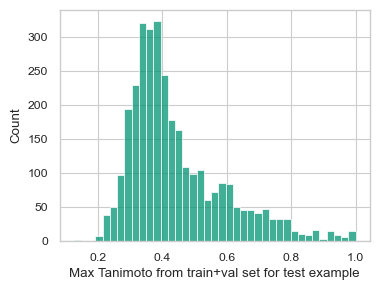

In [15]:
pandarallel.initialize(nb_workers=8, progress_bar=True)
max_train_tanimotos = fps['test'].parallel_apply(lambda f: max_train_tanimoto(f, pd.concat([fps['train'], fps['val']])))
utils.init_plotting(figsize=(4, 3))
sns.histplot(max_train_tanimotos)
plt.xlabel('Max Tanimoto from train+val set for test example')
plt.show()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


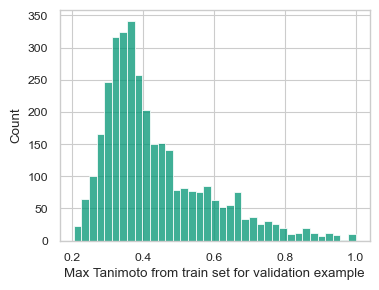

In [16]:
pandarallel.initialize(nb_workers=8, progress_bar=True)
max_train_tanimotos = fps['val'].parallel_apply(lambda f: max_train_tanimoto(f, fps['train']))
utils.init_plotting(figsize=(4, 3))
sns.histplot(max_train_tanimotos)
plt.xlabel('Max Tanimoto from train set for validation example')
plt.show()

In [17]:
df = df_split.drop(columns=['cluster', 'stratification_group'])
df.to_csv('../../data/data/MassSpecGym_split.tsv', sep='\t', index=False)